In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
import copy

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from model import Symmetric, DeepSets, KNN, KK
from sample import generate_data, generate_narrow_data
from train import train
from evaluate import generalization_error, cross_validate

%matplotlib inline

%autosave 0

Autosave disabled


In [2]:
####NOTE: you've edited the compare_models function here, and the nature of the objectives here,
#### and the data distribution in sample.py.  Be aware of this when you update to github again

In [3]:
#For smooth neuron experiment, it's only fair to S2 if the neuron is drawn from the same random features

def smooth_neuron_weight_init(model, objective):
    if objective.__name__ == "smooth_neuron":
        if model.__name__ == "S2" or model.__name__ == "S3":
            with torch.no_grad():
                m = objective.__network__.phi.fc.weight.shape[0]
                model.phi.fc.weight[:m] = objective.__network__.phi.fc.weight
                model.phi.fc.weight.div_(torch.norm(model.phi.fc.weight, dim = 1, keepdim = True))

In [4]:
def compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, objective, narrow, verbose = True, log_plot = False, scaleup = False):
    print("currently", objective.__name__)
    
    bias_first = "neuron" in objective.__name__

    c = 1 if not scaleup else 2

    f1 = Symmetric(input_dim, c * hidden_dim, hidden_dim)
    f2 = KNN(input_dim, c * hidden_dim, hidden_dim)
    f3 = KK(input_dim, c * hidden_dim, hidden_dim)

    f1.__name__ = "S1"
    f2.__name__ = "S2"
    f3.__name__ = "S3"

    models = [f1, f2, f3]
    lambs = [0., 1e-6, 1e-4, 1e-2]
    N_list = np.arange(2, N_max + 16)

    for model in models:
        x, y = generate_data(N_max, batch_size, input_dim, objective, narrow, bias_first)
        
        smooth_neuron_weight_init(model, objective)
        
        cv_models = cross_validate(model, x, y, iterations, lambs, verbose)
        
        validation_errors = np.zeros_like(lambs)
        for i, cv_model in enumerate(cv_models):
            validation_errors[i] = generalization_error([N_max], 1000, input_dim, cv_model, objective, narrow, bias_first)[0]
        
        i = np.argmin(validation_errors)
        lamb = lambs[i]
            
        runs = 10
        run_errors = np.zeros((runs, len(N_list)))
        for i in range(runs):
            x, y = generate_data(N_max, batch_size, input_dim, objective, narrow, bias_first)
            model_copy = copy.deepcopy(model)
            model_copy.reinit()
            smooth_neuron_weight_init(model_copy, objective)
            
            train(model_copy, x, y, iterations, lamb)
            errors = generalization_error(N_list, 1000, input_dim, model_copy, objective, narrow, bias_first)
            run_errors[i] = np.array(errors)
        
        mean_error = np.mean(run_errors, axis = 0)
        std_error = np.std(run_errors, axis = 0)
        if verbose:
            print("performance of ", model.__name__, " on ", objective.__name__)
            print("lamb =", lamb)
            print(mean_error)
            print(std_error)
            
            
        narrow_str = "Narrow" if narrow else "Wide"
        scaleup_str = "scaleup" if scaleup else ""
        save_str = model.__name__ + "_" + objective.__name__ + "_" + narrow_str + "_" + str(input_dim) + scaleup_str
        save_dir = "saved_data/"
            
        np.save(save_dir + save_str + "_mean", mean_error)
        np.save(save_dir + save_str + "_std", std_error)
        
        if log_plot:
            plt.semilogy(N_list, mean_error, label = model.__name__)
        else:
            plt.plot(N_list, mean_error, label = model.__name__)
        plt.fill_between(N_list, mean_error - std_error, mean_error + std_error, alpha = 0.2)

    
    plt.legend()
    plt.ylim([1e-5, 1e-1]) 

    plt.xlabel("N")
    plt.ylabel("Mean Square Error")
    narrow_str = "Narrow" if narrow else "Wide"
    plt.title(narrow_str + " generalization for " + objective.__name__)
    scaleup_str = "scaleup" if scaleup else ""
#     plt.savefig("plots_high_dim/" + objective.__name__ + "_" + narrow_str + "_" + str(input_dim) + scaleup_str)
    plt.show()
    plt.close()

In [5]:
#For the rest of the notebook
input_dim = 20
hidden_dim = 100

In [6]:
mean = lambda x: np.mean(norm(x, axis = 2), axis = 1, keepdims = True)

median = lambda x: np.median(norm(x, axis = 2), axis = 1, keepdims = True)

maximum = lambda x: np.max(norm(x, axis = 2), axis = 1, keepdims = True)

lamb = 0.1
softmax = lambda x: lamb * np.log(np.mean(np.exp(norm(x, axis = 2) / lamb), axis = 1, keepdims = True))

second = lambda x: np.sort(norm(x, axis = 2), axis = 1)[:,-2].reshape(-1,1)

In [19]:
### May need to sample several neurons to find one that isn't degenerate on the domain


teacher = Symmetric(input_dim, hidden_dim, 1)
torch.nn.init.uniform_(teacher.phi.fc.weight, a = -5.0, b = 5.0)
teacher.eval()

def neuron(x):
    x = torch.from_numpy(x).float()
    y = teacher(x)
    return y.data.numpy().reshape(-1, 1)

neuron.__network__ = teacher

x, y = generate_narrow_data(3, 15, input_dim, neuron, bias_first = True)
print(y.data.numpy().flatten())

[0.         0.         2.0728097  0.         1.5568073  0.69953984
 2.0938523  0.         0.         1.027229   0.         1.2256104
 0.         0.52931595 0.        ]


In [24]:
### May need to sample several neurons to find one that isn't degenerate on the domain

smooth_teacher = Symmetric(input_dim, hidden_dim, 1)
torch.nn.init.uniform_(smooth_teacher.rho.fc1.weight,a = -0.3, b = 0.3)  #####NOTE WE CHANGED THIS DISTRIBUTION
smooth_teacher.eval()

def smooth_neuron(x):
    x = torch.from_numpy(x).float()
    y = smooth_teacher(x)
    return y.data.numpy().reshape(-1, 1)

smooth_neuron.__network__ = smooth_teacher

x, y = generate_narrow_data(3, 15, input_dim, smooth_neuron, bias_first = True)
print(y.data.numpy().flatten())

[0.14713562 0.1673548  0.         0.29740074 0.34191653 0.03544381
 0.         0.08250269 0.         0.09708734 0.03513103 0.
 0.         0.249315   0.        ]


In [25]:
neuron.__name__ = "neuron"
smooth_neuron.__name__ = "smooth_neuron"
maximum.__name__ = "maximum"
softmax.__name__ = "softmax"
median.__name__ = "median"
mean.__name__ = "mean"
second.__name__ = "second"

In [26]:
###############################################

In [27]:
#Run to generate plots in Figure 1:

N_max = 4

iterations = 5000
batch_size = 100

currently neuron
check for overfitting power of S1
lowest loss: 1.2960586559529474e-07
performance of  S1  on  neuron
lamb = 0.0
[3.07772815 2.19091212 1.78989518 1.48539362 1.27567654 1.15060768
 1.0099814  0.90520158 0.84034804 0.79063352 0.72249371 0.6856342
 0.64084122 0.60843804 0.56874386 0.53703167 0.51378973 0.4933933 ]
[0.21948138 0.23969493 0.1409932  0.12463346 0.10521614 0.09534564
 0.10881509 0.07967078 0.10812878 0.09335333 0.0943788  0.09677824
 0.08916694 0.08176364 0.09195702 0.08456172 0.08581033 0.08424023]
check for overfitting power of S2
lowest loss: 1.2030059792778047e-07
performance of  S2  on  neuron
lamb = 1e-06
[6.03397989 4.38542159 3.42267613 2.90099151 2.57549555 2.32997921
 2.13873316 2.02946963 1.93294315 1.82449723 1.80314033 1.80078479
 1.75207195 1.71458892 1.67684802 1.68110968 1.6802686  1.6270665 ]
[0.69186259 0.60676778 0.35032321 0.36921801 0.2751665  0.2584802
 0.26898726 0.30937146 0.30779233 0.32956871 0.34629785 0.41849315
 0.44713977 0.46864

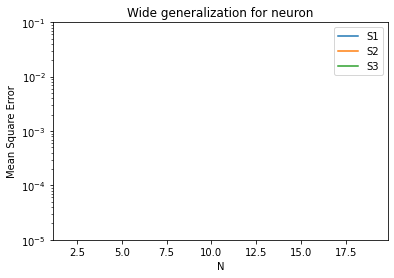

currently neuron
check for overfitting power of S1
lowest loss: 7.562069304078989e-10
performance of  S1  on  neuron
lamb = 0.0
[0.2603927  0.18661046 0.14769464 0.12294797 0.10635583 0.094745
 0.08442998 0.07864425 0.07097444 0.06558663 0.06157725 0.05792054
 0.05582049 0.05441237 0.05107516 0.04864963 0.04589007 0.04430979]
[0.03289967 0.02082429 0.01541748 0.01592831 0.01060471 0.01010865
 0.00882253 0.01087467 0.00876569 0.00635565 0.00530243 0.00518612
 0.00684454 0.00691962 0.00599758 0.00606228 0.00597821 0.0057028 ]
check for overfitting power of S2
lowest loss: 6.900147228768028e-13
performance of  S2  on  neuron
lamb = 1e-06
[0.49775384 0.34589155 0.26904541 0.22264328 0.1936088  0.18167138
 0.16123206 0.14215597 0.14362418 0.12819259 0.12218393 0.11488187
 0.11239307 0.10862097 0.10787849 0.10190756 0.09983165 0.0965045 ]
[0.06918707 0.05152014 0.03628946 0.03240562 0.02499352 0.01921791
 0.02241731 0.01491945 0.02000018 0.01601176 0.01531454 0.01595074
 0.01602358 0.0157982

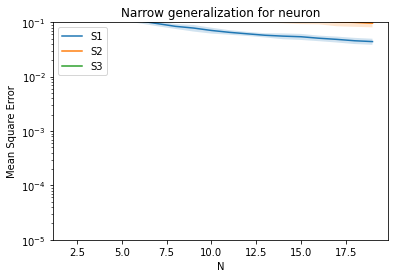

In [28]:
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, mean, narrow = False, log_plot = True)
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , mean, narrow = True, log_plot = True)

# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, median, narrow = False, log_plot = True)
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , median, narrow = True, log_plot = True)

# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, maximum, narrow = False, log_plot = True)
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , maximum, narrow = True, log_plot = True)

# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, softmax, narrow = False, log_plot = True)
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , softmax, narrow = True, log_plot = True)

# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, second, narrow = False, log_plot = True)
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , second, narrow = True, log_plot = True)

compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, neuron, narrow = False, log_plot = True)
compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , neuron, narrow = True, log_plot = True)

# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim, smooth_neuron, narrow = False, log_plot = True)
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , smooth_neuron, narrow = True, log_plot = True)




currently neuron
check for overfitting power of S1
lowest loss: 8.37239023769587e-13
performance of  S1  on  neuron
lamb = 0.0
[0.29290801 0.20258115 0.16190409 0.12908995 0.11266784 0.10176521
 0.0901723  0.08175465 0.07870595 0.0709714  0.06481246 0.06316964
 0.05987025 0.05641626 0.05330793 0.05086017 0.0485563  0.0472844 ]
[0.03189379 0.02512376 0.01737505 0.01518178 0.01294252 0.00817735
 0.01039058 0.007156   0.0053777  0.00662923 0.00469524 0.00640044
 0.0056857  0.00498394 0.00445077 0.00374129 0.0037958  0.00445298]
check for overfitting power of S2
lowest loss: 1.845211761164478e-10
performance of  S2  on  neuron
lamb = 0.0001
[0.35896337 0.25351528 0.20423096 0.17188806 0.14517583 0.13518549
 0.12238147 0.11185441 0.10567773 0.10020328 0.09710282 0.09148902
 0.09038265 0.08652365 0.08339135 0.07793904 0.07533901 0.07613421]
[0.03126573 0.01897603 0.02236847 0.02067227 0.01890134 0.0193713
 0.01870298 0.01823973 0.0189572  0.02018869 0.02005764 0.02096705
 0.02185877 0.022185

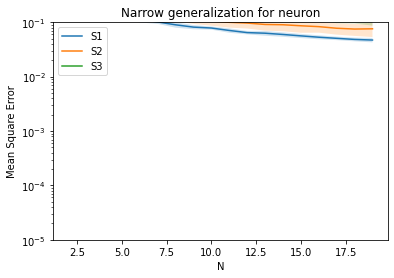

currently neuron
check for overfitting power of S1
lowest loss: 5.8480127407278815e-09
performance of  S1  on  neuron
lamb = 0.01
[0.28830656 0.2021447  0.15198096 0.13336711 0.11420496 0.10154841
 0.09267223 0.08473531 0.07876301 0.07432715 0.06942373 0.06349154
 0.06222348 0.0586492  0.05578797 0.05437443 0.05218105 0.05121831]
[0.02817704 0.02193519 0.01290433 0.01328944 0.00849324 0.00859749
 0.00961863 0.01024644 0.00800118 0.00836453 0.00750612 0.00797278
 0.00908206 0.00757896 0.00676791 0.00787296 0.00835321 0.00914658]
check for overfitting power of S2
lowest loss: 2.0438570974556924e-11
performance of  S2  on  neuron
lamb = 1e-06
[0.48682285 0.34611173 0.26136076 0.2113134  0.17914268 0.16490754
 0.14937132 0.13662472 0.12704628 0.11967127 0.11437947 0.10819306
 0.10106161 0.09671729 0.09512335 0.09180003 0.08963993 0.08842927]
[0.09335126 0.04570643 0.03814827 0.02868751 0.02742859 0.01986347
 0.02292119 0.01477915 0.01384427 0.01651753 0.01837078 0.01866253
 0.01625817 0.01

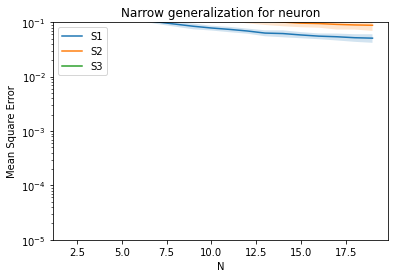

In [29]:
compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , neuron, narrow = True, log_plot = True, scaleup = True)
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , smooth_neuron, narrow = True, log_plot = True, scaleup = True)

compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , neuron, narrow = True, log_plot = True, scaleup = False)
# compare_models(N_max, hidden_dim, iterations, batch_size, input_dim , smooth_neuron, narrow = True, log_plot = True, scaleup = False)



In [ ]:
###############################################

In [ ]:
# objective = neuron
# narrow = True
# bias_first = "neuron" in objective.__name__

# x, y = generate_data(N_max, batch_size, input_dim, objective, narrow, bias_first)

# for i in range(5):
                
#     model = Symmetric(input_dim, hidden_dim, hidden_dim)
#     model.train()
#     losses = train(model, x, y, iterations, lamb = 0.000)
#     model.eval()
#     print(losses[::int(iterations/10)])
#     print("min", np.min(np.array(losses)))
#     print("f1", generalization_error([4], 5000, input_dim, model, objective, narrow, bias_first))
                
#     model = KNN(input_dim, hidden_dim, hidden_dim)
#     model.train()
#     losses = train(model, x, y, iterations, lamb = 0.000)
#     model.eval()
#     print(losses[::int(iterations/10)])
#     print("min", np.min(np.array(losses)))
#     print("f2", generalization_error([4], 5000, input_dim, model, objective, narrow, bias_first))
    
#     model = KK(input_dim, hidden_dim, hidden_dim)
#     model.train()
#     losses = train(model, x, y, iterations, lamb = 0.0)
#     model.eval()
#     print(losses[::int(iterations/10)])
#     print("min", np.min(np.array(losses)))
#     print("f3", generalization_error([4], 5000, input_dim, model, objective, narrow, bias_first))

In [ ]:
#####################################

In [30]:
def plot_from_memory(yrange, input_dim, objectives, narrows, scaleup):
    models = ["S1", "S2", "S3"]
    scaleup_str = "scaleup" if scaleup else ""
    N_list = np.arange(2, 4 + 16)
    
    for objective in objectives:
        for narrow in narrows:
            
            for model in models:
    
                save_str = model + "_" + objective + "_" + narrow + "_" + str(input_dim) + scaleup_str
                save_dir = "saved_data/"
        
                mean_error = np.load(save_dir + save_str + "_mean" + ".npy")
                std_error = np.load(save_dir + save_str + "_std" + ".npy")

                plt.semilogy(N_list, mean_error, label = model)
                plt.fill_between(N_list, mean_error - std_error, mean_error + std_error, alpha = 0.2)


            plt.legend()
            plt.ylim(yrange) 

            plt.xlabel("N")
            plt.ylabel("Mean Square Error")
            narrow_str = narrow
            plt.title(narrow_str + " generalization for " + objective)
            plt.savefig("plots_high_dim/" + objective + "_" + narrow_str + "_" + str(input_dim) + scaleup_str)
            plt.show()
            plt.close()

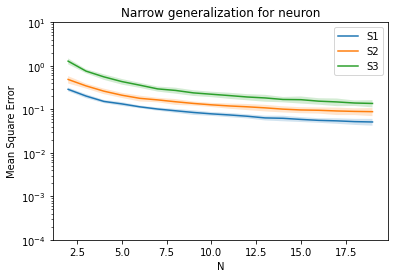

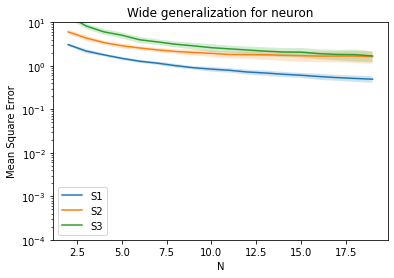

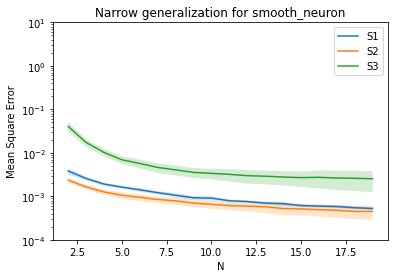

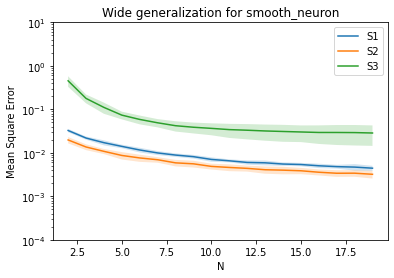

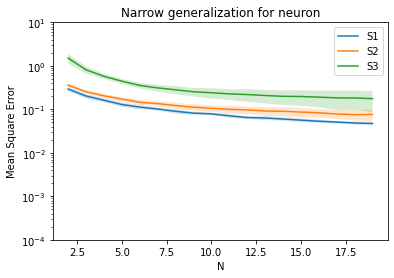

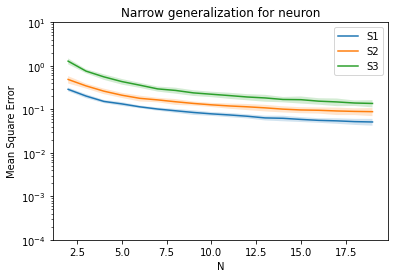

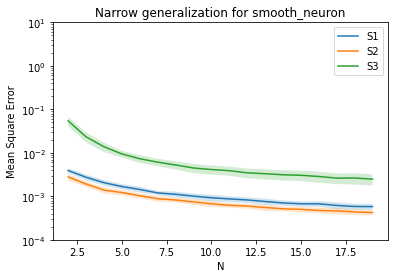

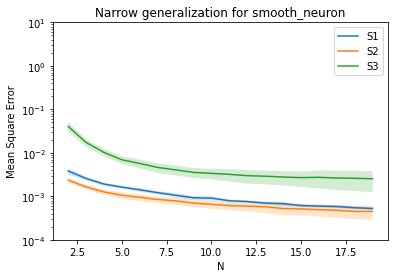

In [31]:
local_input_dim = 20

# plot_from_memory([1e-4, 1e1], local_input_dim, ["mean", "median", "maximum", "softmax", "second"], ["Narrow", "Wide"], False)

plot_from_memory([1e-4, 1e1], local_input_dim, ["neuron"], ["Narrow", "Wide"], False)
plot_from_memory([1e-4, 1e1], local_input_dim, ["smooth_neuron"], ["Narrow", "Wide"], False)

plot_from_memory([1e-4, 1e1], local_input_dim, ["neuron"], ["Narrow"], True)
plot_from_memory([1e-4, 1e1], local_input_dim, ["neuron"], ["Narrow"], False)

plot_from_memory([1e-4, 1e1], local_input_dim, ["smooth_neuron"], ["Narrow"], True)
plot_from_memory([1e-4, 1e1], local_input_dim, ["smooth_neuron"], ["Narrow"], False)